# HW5 ENSEMBLING, TUNNING

# Импорт библиотек

In [43]:
from IPython.display import clear_output
!pip install lightgbm==3.0
!pip install gdown
!pip install optuna
!pip install catboost
!pip install pytorch-tabnet
!pip install -U imbalanced-learn
clear_output()

In [44]:
import catboost
import itertools
import imblearn
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import sklearn.datasets
import xgboost

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, balanced_accuracy_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import matthews_corrcoef
from pytorch_tabnet.tab_model import  TabNetRegressor

Функция для визуализации результата (можете модифицировать).


In [45]:
def plot_regression_predictions(tree_reg, x, y, max_depth, x_range = [0, 1],
                                y_range = [-1, 1]):
    """
    Visualize data and model predictions
    :param tree_reg: trained model,
    :param x: features
    :param y: true values
    :param max_depth: max tree depth
    :param x_range: x range
    :param y_range: y range
    """
    x_pred = np.linspace(x_range[0], x_range[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x_pred)

    plt.xlim(x_range)
    plt.ylim(y_range)

    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("$y$", fontsize=18, rotation=0)

    plt.plot(x, y, "b.", label="data")
    plt.plot(x_pred, y_pred, "r.-", linewidth=2, label=f"max_depth = {max_depth}")
    plt.legend()

# Задание 1. Bootstrap

В этом задании используйте датасет breast_cancer &mdash; классический датасет для задачи бинарной классификации. Обучите модели:

 - `DecisionTreeClassifier`
 -`RandomForestClassifier`
 -`LigthGBMClassifier`
 -`SVC`
 -`BaggingClassifier` с базовым класификатором - SVC .

Параметры моделей можете оставить по умолчанию или задать сами.

Для каждой модели посчитайте [корреляцию Мэтьюса](https://en.wikipedia.org/wiki/Phi_coefficient) &mdash; метрику для оценки качества бинарной классификации, в частности, устойчивую к дисбалансу классов, ([`sklearn.metrics.matthews_corrcoef`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), подробнее почитать про его пользу можно [здесь](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)) для предсказанного ею класса и реального

С помощью bootstrap-подхода постройте 90% доверительные интервалы для качества полученных моделей. Используйте функцию `bootstrap_metric` из лекции ().

Постройте [боксплоты](https://seaborn.pydata.org/generated/seaborn.boxplot.html) для качества полученных моделей

In [46]:
breast_cancer = sklearn.datasets.load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [47]:
x = breast_cancer.data
y = breast_cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [48]:
from lightgbm import LGBMClassifier

dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)
svc = SVC(random_state=42)
b = BaggingClassifier(estimator=SVC(), random_state=42)

In [49]:
dt.fit(x_train, y_train)
rf.fit(x_train, y_train)
lgbm.fit(x_train, y_train)
svc.fit(x_train, y_train)
b.fit(x_train, y_train)

p_dt = dt.predict(x_test)
p_rf = rf.predict(x_test)
p_lgbm = lgbm.predict(x_test)
p_svc = svc.predict(x_test)
p_b = b.predict(x_test)

In [50]:
from sklearn.metrics import matthews_corrcoef

print("matthews_corrcoef")
print("DecisionTreeClassifier: ", matthews_corrcoef(y_test, p_dt))
print("RandomForestClassifier: ", matthews_corrcoef(y_test, p_rf))
print("LGBMClassifier: ", matthews_corrcoef(y_test, p_lgbm))
print("SVC: ", matthews_corrcoef(y_test, p_svc))
print("BaggingClassifier: ", matthews_corrcoef(y_test, p_b))

matthews_corrcoef
DecisionTreeClassifier:  0.8963356530877563
RandomForestClassifier:  0.925445136208044
LGBMClassifier:  0.8963356530877563
SVC:  0.8965050191922527
BaggingClassifier:  0.8965050191922527


In [51]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, alpha=0.05, random_state=42):
    size = len(x)
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]

        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [52]:
boot_score_dt = bootstrap_metric(
    y_test,
    p_dt,
    metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y),
)
boot_score_rf = bootstrap_metric(
    y_test,
    p_rf,
    metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y),
)
boot_score_lgbm = bootstrap_metric(
    y_test,
    p_lgbm,
    metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y),
)
boot_score_svc = bootstrap_metric(
    y_test,
    p_svc,
    metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y),
)
boot_score_b = bootstrap_metric(
    y_test,
    p_b,
    metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y),
)
alpha = 0.10
print(
    "DecisionTreeClassifier mcc 90%-ci:",
    np.quantile(boot_score_dt, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "RandomForestClassifier mcc 90%-ci:",
    np.quantile(boot_score_rf, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "LGBMClassifier mcc 90%-ci:",
    np.quantile(boot_score_lgbm, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "SVC mcc 90%-ci:",
    np.quantile(boot_score_svc, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "BaggingClassifier mcc 90%-ci:",
    np.quantile(boot_score_b, q=[alpha / 2, 1 - alpha / 2]),
)

DecisionTreeClassifier mcc 90%-ci: [0.82974532 0.95585337]
RandomForestClassifier mcc 90%-ci: [0.86842892 0.97140837]
LGBMClassifier mcc 90%-ci: [0.82950665 0.95459809]
SVC mcc 90%-ci: [0.83030554 0.95532067]
BaggingClassifier mcc 90%-ci: [0.83030554 0.95532067]


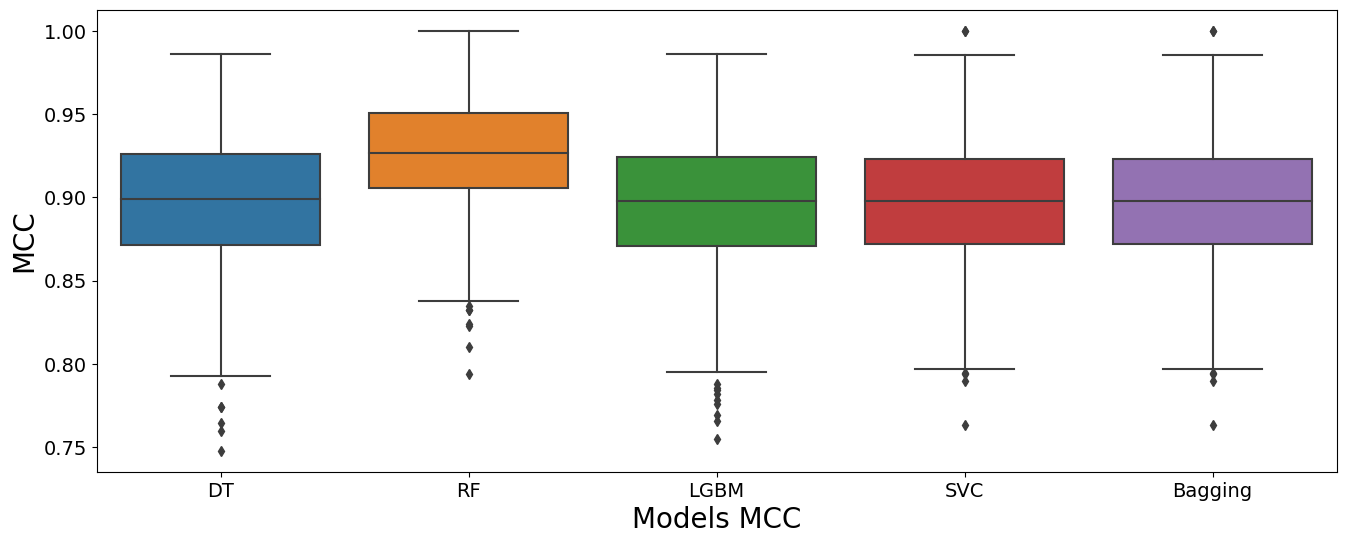

In [53]:
plt.figure(figsize=(16, 6))
base_models = ["DT", "RF", "LGBM", "SVC", "Bagging"]
result_arrays = [
    boot_score_dt,
    boot_score_rf,
    boot_score_lgbm,
    boot_score_svc,
    boot_score_b,
]

dfs = []
for i, res in enumerate(result_arrays):
    df = pd.DataFrame(res, columns=["MCC"])
    df["base_model"] = base_models[i]
    dfs.append(df)

sns.boxplot(data=pd.concat(dfs), y="MCC", x="base_model")
plt.xlabel("Models MCC", size=20)
plt.ylabel("MCC", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Сделайте вывод о том, какие модели работают лучше.

**Напишите вывод**

Случайный лес сработал лучше всего по метрике matthews_corrcoef

## Формат результата

График с демонстрацией корреляции Мэтьюса для следующих моделей:

 - `DecisionTreeClassifier`
 -`RandomForestClassifier`
 -`LigthGBMClassifier`
 -`SVC`
 -`BaggingClassifier` с базовым класификатором - SVC .


Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX03/result_2_task_ex03.png" width="600">

# Задание 2. Обучение и подбор параметров

Загрузим датасет с рецептами (состав блюд и дополнительные данные о них) и рейтинге рецептов.

In [54]:
recipies = pd.read_csv("recipes.csv")
print(recipies.iloc[:, 0:5].head())

   calories  protein   fat  sodium  cakeweek
0     426.0     30.0   7.0   559.0       0.0
1     403.0     18.0  23.0  1439.0       0.0
2     165.0      6.0   7.0   165.0       0.0
3     547.0     20.0  32.0   452.0       0.0
4     948.0     19.0  79.0  1042.0       0.0


In [55]:
recipies = recipies.loc[pd.isna(recipies).sum(axis=1)==0, :] # remove na
y = recipies['rating']
x = recipies.drop(["rating"], axis=1)
x_train_all, x_test, y_train_all, y_test = train_test_split(x.values, y.values, train_size=0.7, random_state=42)

Постройте модель, предсказывающую рейтинг рецепта по всем имеющимся признакам. Для анализа качества моделей используйте метрику `MSE`.

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже.

1. `xgboost.XGBRegressor`
2. `xgboost.XGBRFRegressor` (случайный лес от xgboost)
3. `lightgbm.LGBMRegressor`
4. `lightgbm.LGBMRegressor(boosting_type="rf")` (случайный лес от lightgbm)
5. `catboost.CatBoostRegressor`

Кроме этого, используйте так же
`TabNetRegressor`. Установите число эпох (`max_epochs`, параметр функции `fit`) равным 30.

Для первых двух моделей попытайтесь оптимизировать их параметры, чтобы получить хорошее качество.

Сравните качество полученных моделей.

In [56]:
lgbmr = lightgbm.LGBMRegressor(objective='regression', random_state=42)

param_grid0 = {
    'num_leaves': np.arange(10, 60, 10),
    'max_depth': np.arange(1, 15),
    'learning_rate': [0.01, 0.1],
    'n_estimators': np.arange(1, 190, 50),
    'min_child_samples': np.arange(1, 15),
}

search0 = GridSearchCV(lgbmr, param_grid0, n_jobs=-1, cv=5, refit=True, scoring='neg_mean_squared_error')
search0.fit(x_train_all, y_train_all)
print(search0.best_params_)

{'learning_rate': 0.1, 'max_depth': 13, 'min_child_samples': 1, 'n_estimators': 51, 'num_leaves': 20}


In [57]:
xgbrf = xgboost.XGBRFRegressor(random_state=42)

param_grid1 = {
    'max_depth': np.arange(1, 15),
    'max_leaves': np.arange(10, 60, 10),
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': np.arange(1, 190, 50),
}

search1 = GridSearchCV(xgbrf, param_grid1, n_jobs=-1, cv=5, refit=True, scoring='neg_mean_squared_error')
search1.fit(x_train_all, y_train_all)
print(search1.best_params_)

{'learning_rate': 1, 'max_depth': 7, 'max_leaves': 50, 'n_estimators': 151}


In [58]:
lgbmr = lightgbm.LGBMRegressor(objective='regression', learning_rate=0.1, max_depth=13, min_child_samples=1, n_estimators=51, num_leaves=20, random_state=42)
lgbmr.fit(x_train_all, y_train_all)
p_lgbmr = lgbmr.predict(x_test)

xgbrf = xgboost.XGBRFRegressor(learning_rate=1, max_depth=7, max_leaves=50, n_estimators=151, random_state=42)
xgbrf.fit(x_train_all, y_train_all)
p_xgbrf = xgbrf.predict(x_test)

print("MSE LGBMR: ", mean_squared_error(y_test, p_lgbmr))
print("MSE XGBRFR: ", mean_squared_error(y_test, p_xgbrf))
print("RMSE LGBMR: ", mean_squared_error(y_test, p_lgbmr, squared=False))
print("RMSE XGBRFR: ", mean_squared_error(y_test, p_xgbrf, squared=False))

MSE LGBMR:  1.5354738887931243
MSE XGBRFR:  1.5391783190444213
RMSE LGBMR:  1.2391424005307559
RMSE XGBRFR:  1.2406362557351052


In [59]:
model = TabNetRegressor()
model.fit(X_train=x_train_all, y_train=y_train_all.reshape(-1, 1), max_epochs=30)
y_pred = model.predict(x_test)

print("MSE TabNetR: ", mean_squared_error(y_test, y_pred))
print("RMSE TabNetR: ", mean_squared_error(y_test, y_pred, squared=False))

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 8.55163 |  0:00:00s
epoch 1  | loss: 3.70914 |  0:00:01s
epoch 2  | loss: 2.56407 |  0:00:02s
epoch 3  | loss: 2.23444 |  0:00:03s
epoch 4  | loss: 1.86111 |  0:00:03s
epoch 5  | loss: 1.7512  |  0:00:04s
epoch 6  | loss: 1.72731 |  0:00:04s
epoch 7  | loss: 1.68901 |  0:00:05s
epoch 8  | loss: 1.66025 |  0:00:05s
epoch 9  | loss: 1.66505 |  0:00:06s
epoch 10 | loss: 1.64722 |  0:00:06s
epoch 11 | loss: 1.6494  |  0:00:07s
epoch 12 | loss: 1.65986 |  0:00:07s
epoch 13 | loss: 1.6396  |  0:00:08s
epoch 14 | loss: 1.64078 |  0:00:08s
epoch 15 | loss: 1.62351 |  0:00:09s
epoch 16 | loss: 1.62486 |  0:00:09s
epoch 17 | loss: 1.59909 |  0:00:10s
epoch 18 | loss: 1.58348 |  0:00:10s
epoch 19 | loss: 1.60819 |  0:00:11s
epoch 20 | loss: 1.61733 |  0:00:11s
epoch 21 | loss: 1.62046 |  0:00:12s
epoch 22 | loss: 1.61225 |  0:00:12s
epoch 23 | loss: 1.62325 |  0:00:13s
epoch 24 | loss: 1.58215 |  0:00:13s
epoch 25 | loss: 1.62376 |  0:00:14s
epoch 26 | loss: 1.58939 |  0:00:15s
e

Сравните качество моделей с гиперпараметрами, подобранными вручную и бустинга `LightGBM` с гиперпараметрами, оптимизированными автоматически с помощью фреймворка [`optuna`](https://optuna.org/).

`optuna` используется для подбора гиперпараметров различных моделей машинного обучения и встретится в этом курсе ещё неоднократно. В частности для оптимизации градиентного бустинга `LightGBM` используется функция `optuna.integration.lightgbm.LightGBMTunerCV`. Другие функции можно найти по [ссылке](https://optuna.readthedocs.io/en/stable/reference/integration.html).

Используйте параметры, полученные при оптимизации модели с помошью `optuna.integration.lightgbm.LightGBMTunerCV` для обучения модели `LightGBM`.

Сравните качество полученных моделей.

In [60]:
?optuna.integration.lightgbm.LightGBMTunerCV

In [61]:
dtrain = optuna.integration.lightgbm.Dataset(x_train_all, label=y_train_all)

params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt"}

tuner = optuna.integration.lightgbm.LightGBMTunerCV(params=params,
                                                    train_set=dtrain,
                                                    #verbose_eval=False,
                                                    #early_stopping_rounds=100,
                                                    time_budget=600,
                                                    folds=KFold(n_splits=4, shuffle=True),
                                                    seed=42)

tuner.run()

print("\nBest score:", tuner.best_score)
best_params = tuner.best_params
print("\nBest parameters: ")
for key, value in best_params.items():
    print(f"{key}: {value}")

[I 2023-12-02 13:58:50,514] A new study created in memory with name: no-name-8dd38610-3290-4757-b8a6-be1876b46ad3
min_child_samples, val_score: 1.244344: 100%|##########| 5/5 [00:10<00:00,  2.14s/it]


Best score: 1.2443442032875158

Best parameters: 
objective: regression
metric: rmse
verbosity: -1
boosting_type: gbdt
feature_pre_filter: False
lambda_l1: 7.091076815042936
lambda_l2: 1.85470728945877e-08
num_leaves: 3
feature_fraction: 0.4
bagging_fraction: 0.4151759684098873
bagging_freq: 5
min_child_samples: 20


In [62]:
lgbmoptun = lightgbm.LGBMRegressor(**tuner.best_params)
lgbmoptun.fit(x_train_all, y_train_all)
y_pred0 = lgbmoptun.predict(x_test)

print("MSE Optuna: ", mean_squared_error(y_test, y_pred0))
print("RMSE Optuna: ", mean_squared_error(y_test, y_pred0, squared=False))

MSE Optuna:  1.5470038430611697
RMSE Optuna:  1.2437860921642312


MSE:

1. Бустинг:  1.5354738887931243
2. Случаный лес:  1.5391783190444213
3. TabNetR:  1.6632445496409536
4. С использованием Optuna:  1.5470038430611697

## Формат результата

Получить значения MSE для моделей:

1. Случайный лес ~ 1.4
2. Бустинг меньше 1.45
3. TabNet ~ 1.5
4. С использованием optuna ~ 1.3

# Задание 3. Дисбаланс классов

Важно обращать внимание на сбалансированность классов в наборе.
Предположим, у нас есть некоторый набор данных со следующими метками классов:

In [63]:
real_labels  = [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

В наборе 16 объектов относятся к классу 0, 5 к классу 1.

Мы обучили две модели. Первая всегда выдает 0:

In [64]:
model1_res = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Вторая сумела обнаружить некоторую закономерность в признаках:

In [65]:
model2_res = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

Рассчитаем точность Accuracy для этих моделей:

In [66]:
print("Accuracy for model1: ", accuracy_score(real_labels, model1_res))
print("Accuracy for model2: ", accuracy_score(real_labels, model2_res))

Accuracy for model1:  0.7619047619047619
Accuracy for model2:  0.7619047619047619


Accuracy нельзя использовать, если данные не сбалансированы!!!. Для несбалансированных данных необходимо использовать свои метрики и модели. Одной из таких метрик является balanced accuracy. При вычислении данной метрики считается полнота (recall) отдельно для каждого класса и вычисляется среднее значение:

In [67]:
# Balanced accuracy for model1 = (16/16+0/5)/2 = 0.5
print("Balanced accuracy for model1: ", balanced_accuracy_score(real_labels, model1_res))
# Balanced accuracy for model2 = (12/16+4/5)/2 = 0.775
print("Balanced accuracy for model2: ", balanced_accuracy_score(real_labels, model2_res))

Balanced accuracy for model1:  0.5
Balanced accuracy for model2:  0.775


**Всегда проверяйте** являются ли ваши данные сбалансированными и могут ли выбранные для оценки модели метрики работать с несбалансированными классами.

Загрузим датасет с различными биомаркерами пациентов с меланомой (обезличенный, информации о пациентах нет) и переменной, содержащей 1, если пациент ответил на иммунотерапию (терапия помогла пациенту и произошло уменьшение размеров опухоли) и 0, если не ответил. Количество пациентов, отвечающих на терапию сильно меньше пациентов, которым терапия не помогает, поэтому предсказание ответа пациента на терапию на основании биомаркеров &mdash; актуальная задача в онкологии. В данном задании вам предстоит попробовать её решить.

In [68]:
cancer = pd.read_table("Cancer_dataset_2.tsv", index_col='sample_id')
display(cancer.head())

# split the data on features (x) and dependant variable (y)
y = cancer['Response']
x = cancer.drop('Response', axis=1)
print('\nNumber of patients responded to immunotherapy:')
display(y.value_counts())

,IgG1/IgA,IL21,CXCL9,CXCL10,CD8A,GZMB,KLRC2,KLRC3,KLRC4,GNLY,TGFB1,Response
sample_id,,,,,,,,,,,,
SAM4b0175e8db6e,3.242746,0.001280,-0.002986,-0.036366,0.096658,0.063467,0.502058,-0.083862,0.053659,0.091930,61.934119,0
SAMd215b503f99a,2.139016,-0.000089,0.030495,0.243958,0.161128,0.565798,-0.203495,-0.026902,-0.035405,0.030125,103.265837,0
SAM7fb6987514a4,12.614972,0.008103,0.502043,0.530783,0.388455,0.528142,-0.156209,0.001147,-0.028690,0.260703,53.552817,0
SAMd636e3461955,6.365973,-0.000139,0.024035,0.115127,0.084455,0.200038,-0.387373,-0.057837,0.045938,0.073192,80.837318,0
SAMc0da5d48686d,2.764089,0.006107,0.015533,0.135470,0.067686,0.053499,-0.116040,0.063714,0.088201,0.082940,114.422926,0



Number of patients responded to immunotherapy:


0    228
1     37
Name: Response, dtype: int64

В данном случае имеет место несбалансированность классов в наборе данных: пациентов, ответивших на терапию, гораздо меньше.

Есть два способа работы с несбалансированными по классам данными. Первый способ &mdash; это получение стратифицированных выборок. Необходимо иметь одинаковую долю образцов каждого класса в тренировочной и тестовой выборках, иначе возникает риск получения смещённых выборок, что приводит к некорректной оценке качества модели. Второй способ &mdash; это использование специальных алгоритмов, учитывающих несбалансированность классов.


В данном задании вам нужно продемонстрировать эффективность различных подходов  работы с несбалансированными выборками. Для этого вы будете использовать три модели, представленные ниже:

1. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn
2. [`RandomForestClassifier` с балансировкой классов](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn  - меняет стандартный вес каждого класса, равный 1, на долю класса во входных данных (см. `class_weight`).
3. [`BalancedRandomForestClassifier`](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html), библиотека imblearn - сэмплирует псевдовыборки таким образом, что в каждой псевдовыборке, которая подается на вход модели, баланс классов оказывается "выправлен".

Оцените эффективность подходов с помощью кросс-валидации, производя разбиение с учетом репрезентации классов и без него. В качестве метрики, отображающей эффективность модели, используйте значения `accuracy` и `balanced_accuracy`. Проинтерпретируйте результаты.

In [69]:
?imblearn.ensemble.BalancedRandomForestClassifier

In [70]:
?cross_validate

Объекты, принадлежащие разным классам, распределены неравномерно. Для адекватной работы cross_validate нужно перемешать данные. Для этого используйте флаг shuffle=True, применяя `KFold` и `StratifiedKFold` (см. параметр `cv` в функции cross_validate).

RandomForestClassifier

In [71]:
rf0 = RandomForestClassifier(random_state=42)
kf = KFold(shuffle=True, random_state=42)

cv_KFold_accu = cross_validate(rf0, x, y, cv=kf, scoring='accuracy')
cv_KFold_baccu = cross_validate(rf0, x, y, cv=kf, scoring='balanced_accuracy')

print('KFold')
print('Accuracy:',np.mean(cv_KFold_accu['test_score']))
print('Balanced Accuracy:',np.mean(cv_KFold_baccu['test_score']))

KFold
Accuracy: 0.8528301886792453
Balanced Accuracy: 0.5560479797979798


In [72]:
rf1 = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(shuffle=True, random_state=42)

cv_StratifiedKFold_accu = cross_validate(rf1, x, y, cv=skf, scoring='accuracy')
cv_StratifiedKFold_baccu = cross_validate(rf1, x, y, cv=skf, scoring='balanced_accuracy')

print('StratifiedKFold')
print('Accuracy:',np.mean(cv_StratifiedKFold_accu['test_score']))
print('Balanced Accuracy:',np.mean(cv_StratifiedKFold_baccu['test_score']))

StratifiedKFold
Accuracy: 0.8566037735849058
Balanced Accuracy: 0.5304451345755694


RandomForestClassifier с балансировкой классов

In [73]:
rfb0 = RandomForestClassifier(class_weight='balanced', random_state=42)
sk = KFold(shuffle=True, random_state=42)

cv_KFold_accu = cross_validate(rfb0, x, y, cv=kf, scoring='accuracy')
cv_KFold_baccu = cross_validate(rfb0, x, y, cv=kf, scoring='balanced_accuracy')

print('KFold')
print('Accuracy:',np.mean(cv_KFold_accu['test_score']))
print('Balanced Accuracy:',np.mean(cv_KFold_baccu['test_score']))

KFold
Accuracy: 0.8641509433962264
Balanced Accuracy: 0.555182946486138


In [74]:
rfb1 = RandomForestClassifier(class_weight='balanced', random_state=42)
skf = StratifiedKFold(shuffle=True, random_state=42)

cv_StratifiedKFold_accu = cross_validate(rfb1, x, y, cv=skf, scoring='accuracy')
cv_StratifiedKFold_baccu = cross_validate(rfb1, x, y, cv=skf, scoring='balanced_accuracy')

print('StratifiedKFold')
print('Accuracy:',np.mean(cv_StratifiedKFold_accu['test_score']))
print('Balanced Accuracy:',np.mean(cv_StratifiedKFold_baccu['test_score']))

StratifiedKFold
Accuracy: 0.8679245283018868
Balanced Accuracy: 0.5491752933057281


BalancedRandomForestClassifier

In [75]:
brfc0 = imblearn.ensemble.BalancedRandomForestClassifier(sampling_strategy="auto", replacement=False, random_state=42)
sk = KFold(shuffle=True, random_state=42)

cv_KFold_accu = cross_validate(brfc0, x, y, cv=kf, scoring='accuracy')
cv_KFold_baccu = cross_validate(brfc0, x, y, cv=kf, scoring='balanced_accuracy')

print('KFold')
print('Accuracy:',np.mean(cv_KFold_accu['test_score']))
print('Balanced Accuracy:',np.mean(cv_KFold_baccu['test_score']))

KFold
Accuracy: 0.6716981132075472
Balanced Accuracy: 0.6918281216419515


In [76]:
brfc1 = imblearn.ensemble.BalancedRandomForestClassifier(sampling_strategy="auto", replacement=False, random_state=42)
skf = StratifiedKFold(shuffle=True, random_state=42)

cv_StratifiedKFold_accu = cross_validate(brfc1, x, y, cv=skf, scoring='accuracy')
cv_StratifiedKFold_baccu = cross_validate(brfc1, x, y, cv=skf, scoring='balanced_accuracy')

print('StratifiedKFold')
print('Accuracy:',np.mean(cv_StratifiedKFold_accu['test_score']))
print('Balanced Accuracy:',np.mean(cv_StratifiedKFold_baccu['test_score']))

StratifiedKFold
Accuracy: 0.6566037735849057
Balanced Accuracy: 0.672803657694962


Какая модель лучше справляется с дисбалансом классов?

**Напишите вывод**

BalancedRandomForestClassifier лучше всех справился с дисбалансом классов классов если смотреть на метрику balanced_accuracy

## Формат результата

Для моделей:
1. `RandomForestClassifier`, библиотека sklearn
2. `RandomForestClassifier с балансировкой классов`, библиотека sklearn
3. `BalancedRandomForestClassifier`, библиотека imblearn

Получить значения `accuracy` и `balanced_accuracy` при `KFold`-кроссвалидации и `StratifiedKFold`-кроссвалидации.

# Задание 4. Корреляция базовых моделей (maybe HARD - EXTRA)*

Для случайного леса, на примере датасета breast_cancer, постройте зависимость между попарными корреляциями базовых моделей и числом фичей, которые отбираются в каждую модель.


In [77]:
breast_cancer = sklearn.datasets.load_breast_cancer()

x = breast_cancer.data
y = breast_cancer.target

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [78]:
paircor = []

for num_features in range(1, x.shape[1] + 1):
    rf = RandomForestClassifier(max_features=num_features, random_state=42)
    rf.fit(x_train, y_train)

    forest_estimators = rf.estimators_
    pred = np.array([base_model.predict(x_test) for base_model in forest_estimators])

    cor = np.corrcoef(pred)
    paircor.append(cor[np.triu_indices(cor.shape[0], 1)])

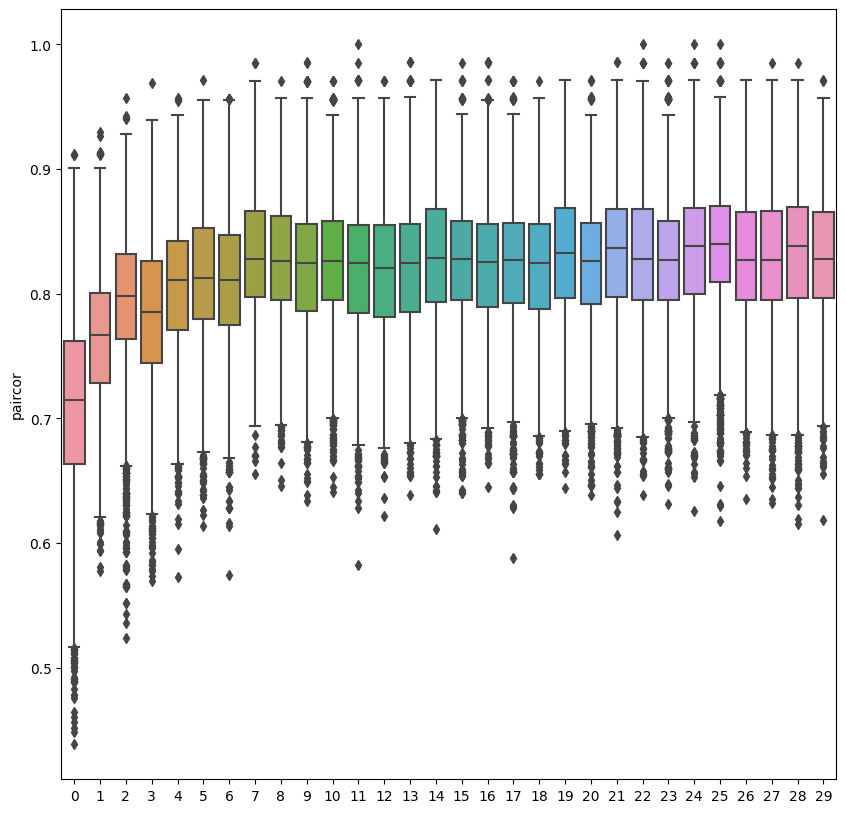

In [79]:
plt.figure(figsize=(10, 10))
sns.boxplot(data = paircor)
plt.ylabel("paircor", size=10)
plt.show()

В параграфе лекции **Метод случайных подпространств** дана информация о рекомендованном количестве признаков для задачи классификации. Как соотносится полученный график и рекомендуемое количество признаков?

**Напишите вывод**

Обычно для задач классификации выбирают:

 $$\sqrt{feature\_cnt}$$

 В нашем случае это соответсвует умеренной корреляции


## Формат результата

График зависимости между попарными корреляциями базовых моделей и числом фичей, которые отбираются в каждую модель.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX03/result_5_task_ex03.png" width="600">